Total number of data points loaded: 998
Training set size: 647
Test set size: 351
Acuuracy: 0.6011396011396012
Confusion Matrix:
[[17  1  3  1  0  0  2  0  1  3]
 [ 0 38  1  0  0  4  0  0  0  0]
 [ 1  0 22  2  2  3  0  3  0  3]
 [ 0  1  3 12  4  1  2  3  0  5]
 [ 0  0  1  6 18  1  3  4  4  4]
 [ 3  1  2  2  3 17  0  1  2  4]
 [ 3  0  0  2  2  0 29  0  0  1]
 [ 0  0  0  0  3  0  0 25  0  0]
 [ 0  0  4  2  4  6  1  3 19  1]
 [ 0  0  1  8  1  0  1  2  5 14]]


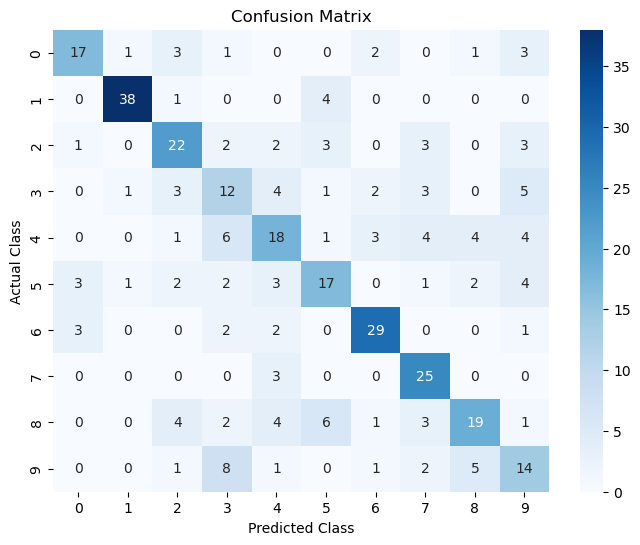

In [2]:

from python_speech_features import mfcc 
import scipy.io.wavfile as wav 
import numpy as np 
from scipy.spatial.distance import euclidean
from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import math
import numpy as np 
def getNeighbors(trainingSet, instance, k):
    distances = []
    
    # Calculate distances between the input instance and each training instance
    for training_instance in trainingSet:
        # Calculate the distance using the imported function
        dist = euclidean(instance[0], training_instance[0])
        
        # Append the class label and distance to the list
        distances.append((training_instance[2], dist))
    
    # Sort distances in ascending order
    distances.sort(key=operator.itemgetter(1))
    
    # Select the first k neighbors
    neighbors = [distances[i][0] for i in range(min(k, len(distances)))]
    
    return neighbors
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response]+=1 
        else:
            classVote[response]=1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]
def getAccuracy(testSet, predictions):
    correct = 0 
    for x in range (len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct+=1
    return 1.0*correct/len(testSet)
def create_data_file(output_file, data_directory):
    # Open the output file
    with open(output_file, 'wb') as f:
        folder_count = 0

        # Iterate over folders in the data directory
        for folder in os.listdir(data_directory):
            folder_count += 1
            #if folder_count == 11:
                #break  # Stop after processing 10 folders

            folder_path = os.path.join(data_directory, folder)
            if os.path.isdir(folder_path):
                # Iterate over files in the folder
                for file_name in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, file_name)
                    if file_name.endswith('.wav'):
                        try:
                            # Read audio file
                            rate, sig = wav.read(file_path)
                            
                            # Calculate MFCC features
                            mfcc_feat = mfcc(sig, rate, winlen=0.02, appendEnergy=False)
                            
                            # Calculate covariance and mean matrix
                            covariance = np.cov(np.matrix.transpose(mfcc_feat))
                            mean_matrix = mfcc_feat.mean(0)
                            
                            # Create a data point tuple
                            data_point = (mean_matrix, covariance, folder_count)
                            
                            # Serialize the data point and write to the file
                            pickle.dump(data_point, f)
                        except Exception as e:
                            print(f"Error processing file {file_path}: {e}")

# Specify the data directory and output file path
data_directory =  r"C:\Users\ishas\OneDrive\Documents\ML Project\Data\genres_original"
output_file_path = "my.dat"

# Create the data file
create_data_file(output_file_path, data_directory)
dataset = []
def loadDataset(filename, split_ratio, trSet, teSet):
    # Check if file exists
    if not os.path.exists(filename):
        print(f"File '{filename}' does not exist.")
        return

    # Reset the dataset list to avoid appending to an existing list
    dataset = []

    # Load data from the binary file
    with open(filename, 'rb') as f:
        while True:
            try:
                data_point = pickle.load(f)
                dataset.append(data_point)
            except EOFError:
                break  # End of file, stop reading

    # Print the number of data points loaded
    print(f"Total number of data points loaded: {len(dataset)}")

    # Split the dataset into training and test sets
    for data_point in dataset:
        if random.random() < split_ratio:
            trSet.append(data_point)
        else:
            teSet.append(data_point)
    
    # Print the sizes of the training and test sets
    print(f"Training set size: {len(trSet)}")
    print(f"Test set size: {len(teSet)}")
testSet = []
trainingSet=[]
loadDataset("my.dat" , 0.66, trainingSet, testSet)
leng = len(testSet)
predictions = []
for x in range (leng):
    predictions.append(nearestClass(getNeighbors(trainingSet ,testSet[x] , 5))) 

accuracy1 = getAccuracy(testSet , predictions)
print("Acuuracy:",accuracy1)

# Calculate the confusion matrix
cm = confusion_matrix([dp[2] for dp in testSet], predictions)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()